# CSCA 5632 (Week4, Part1): Unsupervised Learning - BBC News Classification

## Overview

This week’s mini-project is about classifying news articles using Non-negative Matrix Factorization (NMF) unsupervised leanring model and compare the performance with supervised model. We'll use [Kaggle Competition: BBC News Classification](https://www.kaggle.com/c/learn-ai-bbc/overview) dataset. We're provided with 2 datasets:
- BBC News Train.csv: The train dataset.
- BBC News Test.csv: The test dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import time
from itertools import permutations
import re
%matplotlib inline

In [2]:
# Loading data
train_df = pd.read_csv("data/BBC News Train.csv")
test_df = pd.read_csv("data/BBC News Test.csv")

## Exploratory Data Analysis

In this section, We'll inspect the data, perform data cleaning and text preprocessing 

In [3]:
train_df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


**Observations:** The train dataset comprises 1490 samples, each has 3 attributes: ArticleId (the ID of the article), Text (the content of the article), and Category (the classified category of the article such as business, technology, entertainment...)

In [4]:
train_df.Category.value_counts()

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

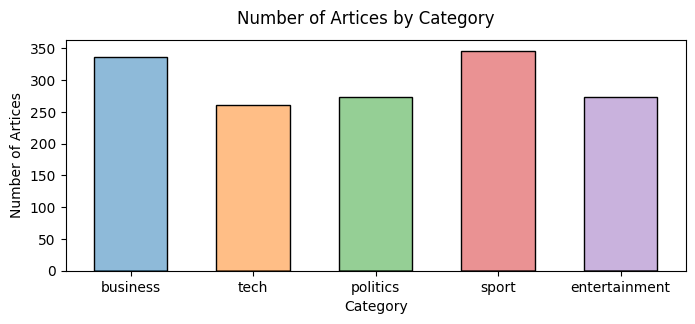

In [5]:
# Display the number of articles by category
fig, ax = plt.subplots(figsize=(8, 3))
fig.suptitle('Number of Artices by Category')
sns.histplot(train_df, x='Category', hue='Category', legend=False, ax=ax, shrink=0.6)
ax.set(xlabel='Category', ylabel='Number of Artices')
plt.show()

**Observations:** There are 5 categories: sport, business, politics, entertainment and tech.

Let's see the article's full content. We'll set the pandas' display max column width to **_'None'_** (default is 50) so that we can see the full content.

In [6]:
# Set pd's display.max_colwidth to 'None' so that we can see full article content
pd.set_option('display.max_colwidth', None)

In [7]:
# Display the first 2 articles / categories 
pd.concat([train_df[train_df['Category']==cate].head(2) for cate in train_df.Category.unique()])

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness. cynthia cooper worldcom s ex-head of internal accounting alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy. prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper who now runs her own consulting business told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a green light to the procedures and practices used by worldcom. mr ebber s lawyers have said he was unaware of the fraud arguing that auditors did not alert him to any problems. ms cooper also said that during shareholder meetings mr ebbers often passed over technical questions to the company s finance chief giving only brief answers himself. the prosecution s star witness former worldcom financial chief scott sullivan has said that mr ebbers ordered accounting adjustments at the firm telling him to hit our books . however ms cooper said mr sullivan had not mentioned anything uncomfortable about worldcom s accounting during a 2001 audit committee meeting. mr ebbers could face a jail sentence of 85 years if convicted of all the charges he is facing. worldcom emerged from bankruptcy protection in 2004 and is now known as mci. last week mci agreed to a buyout by verizon communications in a deal valued at $6.75bn.,business
1,154,german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy. munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up. we re surprised that the ifo index has taken such a knock said dz bank economist bernd weidensteiner. the main reason is probably that the domestic economy is still weak particularly in the retail trade. economy and labour minister wolfgang clement called the dip in february s ifo confidence figure a very mild decline . he said that despite the retreat the index remained at a relatively high level and that he expected a modest economic upswing to continue. germany s economy grew 1.6% last year after shrinking in 2003. however the economy contracted by 0.2% during the last three months of 2004 mainly due to the reluctance of consumers to spend. latest indications are that growth is still proving elusive and ifo president hans-werner sinn said any improvement in german domestic demand was sluggish. exports had kept things going during the first half of 2004 but demand for exports was then hit as the value of the euro hit record levels making german products less competitive overseas. on top of that the unemployment rate has been stuck at close to 10% and manufacturing firms including daimlerchrysler siemens and volkswagen have been negotiating with unions over cost cutting measures. analysts said that the ifo figures and germany s continuing problems may delay an interest rate rise by the european central bank. eurozone interest rates are at 2% but comments from senior officials have recently focused on the threat of inflation prompting fears that interest rates may rise.,business
3,1976,lifestyle governs mobile choice faster better or funkier hardware alone is not going to help phone 

In [8]:
# Reset pd's display max column width 
pd.set_option('display.max_colwidth', 50)

In [9]:
# Check null/missing values
train_df.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

**Observations:** There is no null or missing values

In [10]:
#Check duplicate
train_df.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

**Observations:** There are total 1490 unique articleID but only unique 1440 articles. It means that there are 50 duplicate articles. 

In [11]:
# Create new collum 'Dupicate'
train_df['Dupicate'] = train_df.duplicated(subset=['Text'])
# View duplicate articles by category
train_df[train_df['Dupicate']]['Category'].value_counts()

Category
tech             27
entertainment    10
politics          8
sport             4
business          1
Name: count, dtype: int64

**Obserations:** There are 27 duplicated articles in tech, 10 in entertainment, 8 in politics, 4 in sport and 1 in buniness category.

Duplicate samples can cause bias, overfitting,... that in turn lead to ineffective, inaccurate model prediction. So let's remove them from train dataset.

In [12]:
# Remove duplicate articles from train dataset.
train_df.drop_duplicates(subset=['Text'], inplace=True)
# Reset index
train_df.reset_index(inplace=True)

Now, let's have a look at the test dataset.

In [13]:
test_df

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


**Observations:** The test dataset comprises 735 entries, each has 2 columns: ArticleId (the ID of the article), Text (the content of the article). The Category (label) of each articles were not provided. It's our job to build a model to classify articles provided in test dataset into 5 categories: sport, business, politics, entertainment and tech.

In [14]:
# Check duplication
test_df.nunique()

ArticleId    735
Text         722
dtype: int64

**Observations:** There are 13 duplicate articles in test dataset. However, we cannot remove duplicate articles from the test dataset because we need to submit all predicted lables to Kaggle to get the score of our model.

### Text Preprocessing

Text processing is the very first and most essential step in NLP. Steps involving in this process include (but not limited to):
- Convert all capital letters to lower-case
- Remove punctuation marks
- Remove numbers
- Remove stop words
- Tokenization
- Text Normalization: Stemming, Lemmatization...

**Stemming** is the process of reducing infected words to their root word (stem). For example, 'runner', 'running', 'runs' 'ran' are all reduced to 'run'. Stemming does not consider the context. So it's fast, simple but less accurate than lemmatization.

**Lemmatization** is the process of reducing words to their base form (or lemma). This technique considers the context and the meaning of the words. So it needs more time and computational resource but more accurate than stemming.

In this section, We'll use Natural Language Toolkit (NLTK) library for text processing, and we'll apply lemmatization technique. NLTK library can be downloaded from its website here ([NLTK](https://www.nltk.org)). 

In [ ]:
# Import NLTK library
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dongnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dongnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dongnguyen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dongnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Sentence processing
def process_sentence(lemmatizer, sentence):
    '''
    Sentence processing
    Input:
        lemmatizer: The WordNetLemmatizer object
        sentence: string, the sentence to be process
    Output:
        Non-stop-word lemmatized string
    '''
    words = word_tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    sentence = ' '.join(words)
    return sentence

# Paragraph processing
def process_paragraph(lemmatizer, text):
    '''
    Paragraph processing
    Input:
        lemmatizer: The WordNetLemmatizer object
        text: string, the paragraph text
    Output:
        Lemmatized paragraph after removing stop words, punctuations, and numbers
    '''
    sentences = [process_sentence(lemmatizer, s) for s in sent_tokenize(text)]
    paragraph = ' '.join(sentences)
    paragraph = re.sub(r'[^\w\s]', '', paragraph)
    paragraph = re.sub(r'[0-9]', '', paragraph)
    return paragraph

In [17]:
# Create lemmatizer object
lemmatizer = WordNetLemmatizer()

In [18]:
# Process train data
time0 = time.time()
train_df['LemmaText'] = train_df['Text'].apply(lambda text: process_paragraph(lemmatizer, text))
print(f"Text processing time for train data: {(time.time() - time0):.2f} seconds")

Text processing time for train data: 40.39 seconds


In [19]:
train_df

,index,ArticleId,Text,Category,Dupicate,LemmaText
0,0,1833,worldcom ex-boss launches defence lawyers defe...,business,False,worldcom exboss launch defence lawyer defendin...
1,1,154,german business confidence slides german busin...,business,False,german business confidence slide german busine...
2,2,1101,bbc poll indicates economic gloom citizens in ...,business,False,bbc poll indicates economic gloom citizen majo...
3,3,1976,lifestyle governs mobile choice faster bett...,tech,False,lifestyle governs mobile choice faster better ...
4,4,917,enron bosses in $168m payout eighteen former e...,business,False,enron boss m payout eighteen former enron dir...
...,...,...,...,...,...,...
1435,1485,857,double eviction from big brother model caprice...,entertainment,False,double eviction big brother model caprice holb...
1436,1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,False,dj double act revamp chart show dj duo jk joel...
1437,1487,1590,weak dollar hits reuters revenues at media gro...,business,False,weak dollar hit reuters revenue medium group r...
1438,1488,1587,apple ipod family expands market apple has exp...,tech,False,apple ipod family expands market apple expande...


Let's do the same for test dataset.

In [20]:
# Process test data
time0 = time.time()
test_df['LemmaText'] = test_df['Text'].apply(lambda text: process_paragraph(lemmatizer, text))
print(f"Text processing time for test data: {(time.time() - time0):.2f} seconds")

Text processing time for test data: 19.88 seconds


In [21]:
test_df

,ArticleId,Text,LemmaText
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day head preston queen park ranger ...
1,1319,software watching while you work software that...,software watching work software monitor every ...
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury add ireland woe gordon arcy ruled ...
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heat ongoing public...
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,eu probe alitalia state aid european commissio...
731,373,u2 to play at grammy awards show irish rock ba...,u play grammy award show irish rock band u pla...
732,1704,sport betting rules in spotlight a group of mp...,sport betting rule spotlight group mp peer cal...
733,206,alfa romeos to get gm engines fiat is to sto...,alfa romeo get gm engine fiat stop making sixc...


Now we're done with text pre-processing. Let's see how many words have been reduced. We're going to count the number of words from original text and after being processed and then calulate the word reduced percentage.

In [22]:
train_df['WordCount'] = train_df['Text'].apply(lambda s: len(s.split()))
train_df['LemmaWordCount'] = train_df['LemmaText'].apply(lambda s: len(s.split()))
train_df['PercentWordReduced'] = (train_df['WordCount'] - train_df['LemmaWordCount'])/train_df['WordCount']
print("Average Word Reduced Percentage for train dataset:", train_df['PercentWordReduced'].sum()/len(train_df))
# Apply on test dataset
test_df['WordCount'] = test_df['Text'].apply(lambda s: len(s.split()))
test_df['LemmaWordCount'] = test_df['LemmaText'].apply(lambda s: len(s.split()))
test_df['PercentWordReduced'] = (test_df['WordCount'] - test_df['LemmaWordCount'])/test_df['WordCount']
print("Average Word Reduced Percentage for test dataset:", test_df['PercentWordReduced'].sum()/len(test_df))

Average Word Reduced Percentage for train dataset: 0.440832594119169
Average Word Reduced Percentage for test dataset: 0.4395613292955467


**Observations:** Applying text-processing techniques such as lemmatization also helps reduce a lot of words. As in our case, it helped reduce 44 percent of words. This definitely helps saving a lot of computational resources on training our models.

### Handling Outliers

In this section, we're going to inspect ouliers and removing them from the train dataset.

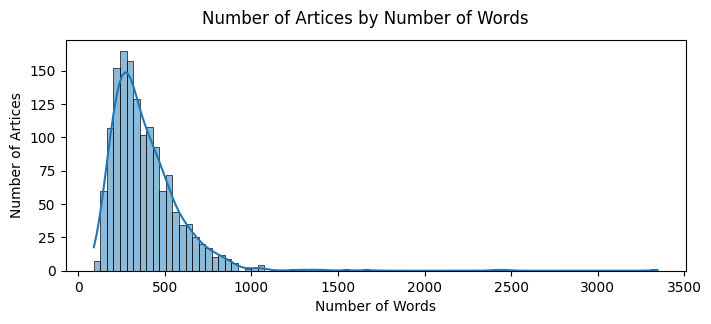

In [23]:
# Plot the Number of Artices by Number of Words
fig, ax = plt.subplots(figsize=(8, 3))
fig.suptitle('Number of Artices by Number of Words')
sns.histplot(train_df, x='WordCount', kde=True, ax=ax)
ax.set(xlabel='Number of Words', ylabel="Number of Artices")
plt.show()

**Observations:** It is clearly that almost articles are less than 1000 words but there are also a few articles that are up to 3000 words long.

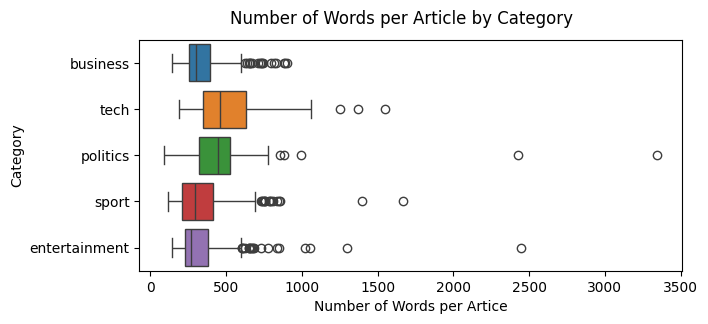

In [24]:
# Plot Number of Words per Article by Category
fig, ax = plt.subplots(figsize=(7, 3))
fig.suptitle('Number of Words per Article by Category')
sns.boxplot(ax=ax, data=train_df, y='Category', x='WordCount', hue='Category')
ax.set(xlabel='Number of Words per Artice', ylabel='Category')
#plt.xticks(rotation=45, ha='right')
plt.show()

**Observations:** Tech and politics news articles tend to be longer than others. There are outliers and we'll going to remove them from train dataset.

In [25]:
# Remove outliers in each category using IRQ
for cate in train_df.Category.unique():
    train_cate = train_df[train_df['Category'] == cate]
    q1 = train_df['WordCount'].quantile(0.25)
    q3 = train_df['WordCount'].quantile(0.75)
    lower_limit = q1 - 1.5 * (q3-q1)
    upper_limit = q3 + 1.5 * (q3-q1)
    train_df = train_df[(train_df['Category'] != cate) | ((train_df['WordCount']>=lower_limit) & (train_df['WordCount']<=upper_limit))]

Let's see the plots again after removing outliers.

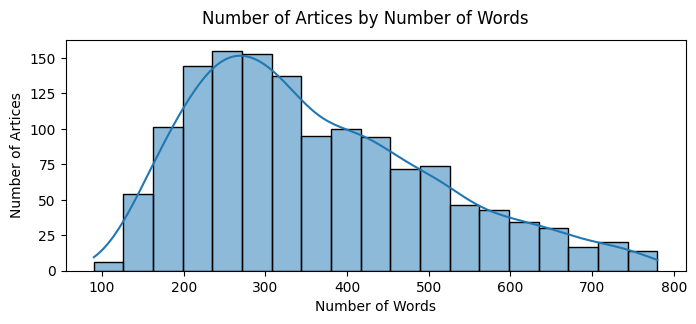

In [26]:
# Plot the Number of Artices by Number of Words
fig, ax = plt.subplots(figsize=(8, 3))
fig.suptitle('Number of Artices by Number of Words')
sns.histplot(train_df, x='WordCount', kde=True, ax=ax)
ax.set(xlabel='Number of Words', ylabel="Number of Artices")
plt.show()

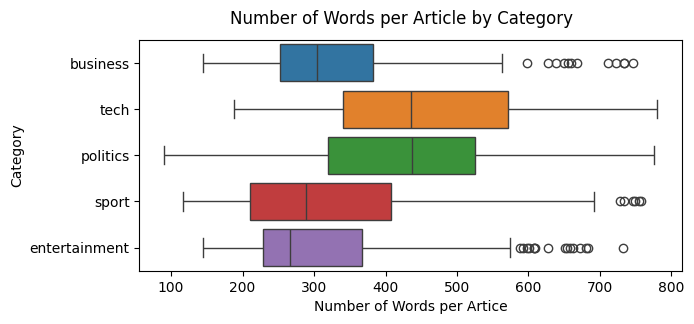

In [27]:
# Plot Number of Words per Article by Category
fig, ax = plt.subplots(figsize=(7, 3))
fig.suptitle('Number of Words per Article by Category')
sns.boxplot(ax=ax, data=train_df, y='Category', x='WordCount', hue='Category')
ax.set(xlabel='Number of Words per Artice', ylabel='Category')
#plt.xticks(rotation=45, ha='right')
plt.show()

### Finding important words

It's interesting to know which words are appears frequently in each category of articles. We'll use **Term Frequency-Inverse Document Frequency (TF-IDF)** to assess the importance of a word in a article relative to sport, business, politics, entertainment and technology.

**Term Frequency-Inverse Document Frequency(TF-IDF)** is a simple measure of a word’s importance within a set of documents. It is commonly used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus). It combines two components: Term Frequency (TF) and Inverse Document Frequency (IDF).

**Term Frequency (TF):** The number of times a term occurs in a given document. 

**Inverse Document Frequency (IDF):** is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient).

We'll use sklearn's **TfidfVectorizer** to transform all raw documents (articles) to a matrix of TF-IDF features and extract and display important or significant words in each category of articles. More information about **TfidfVectorizer** can be found here ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).



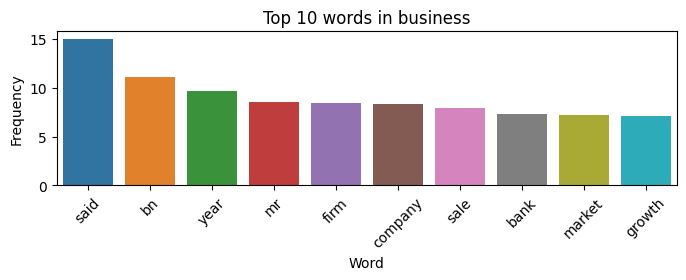

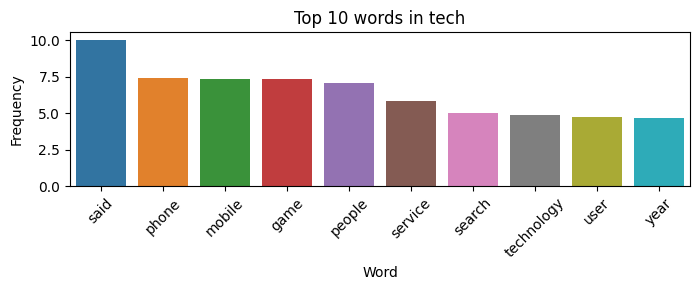

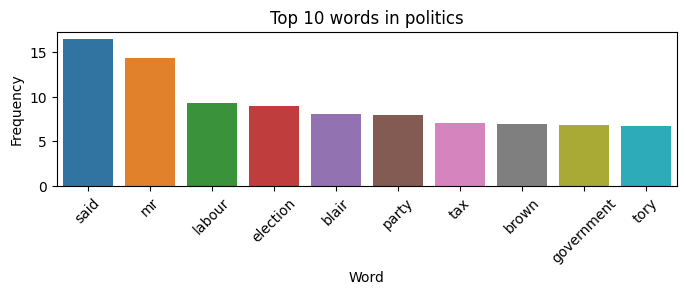

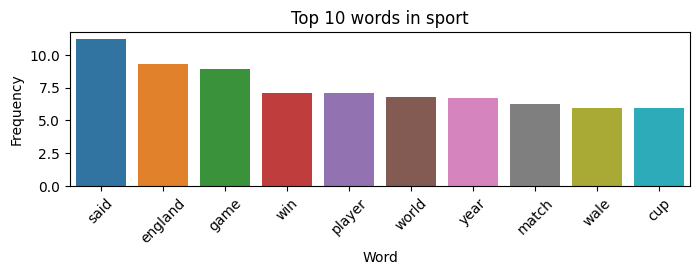

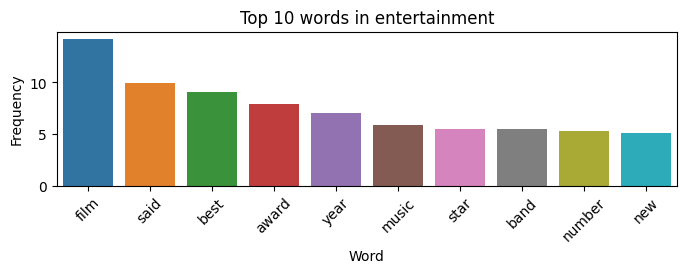

In [28]:
# Create TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.95, ngram_range=(1, 2), stop_words='english')
top_n_words = 10
for cate in train_df.Category.unique():
    tfidf = tfidf_vectorizer.fit_transform(train_df[train_df['Category']==cate]["LemmaText"])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_top_n = pd.DataFrame({'term': feature_names, 'frequency': tfidf.sum(axis=0).A1}).sort_values(by='frequency',ascending=False).head(top_n_words)
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.barplot(data=tfidf_top_n, ax=ax, x='term', y='frequency', hue='term')
    ax.set(xlabel='Word', ylabel="Frequency")
    ax.set_title(f"Top {top_n_words} words in {cate}")
    plt.xticks(rotation=45)
    plt.show()

## Unsupervised Learning Model

In this section, we'll build unsupervised learning models to predict the article's category using **Non-Negative Matrix Factorization (NMF)** from sklearn library. More information about sklearn's NMF can be found here: [Non-Negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

NMF helps break down a large, non-negative matrix X into two smaller non-negative matrices (W and H) such that the product of W and H are approximately equal to X: X = W*H. The dimensions of W and H are chosen such that they capture the essential features of the data while reducing dimensionality.

### Prepare NMF Model

To fit the model, we will need to convert the raw text into numerical data. Again, we'll use sklearn's **TfidfVectorizer** to convert into TF-IDF matrix and the fit the NMF model. For unsupervised model, we'll combine the train and test datasets.

In [43]:
# Assign unique numbers for text lables 
labels = np.unique(train_df.Category)
mapping_labels = dict(zip(labels, list(range(len(labels)))))
print(mapping_labels)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [30]:
# Add new column that represents the numerical labels to the train dataset 
train_df['Label'] = train_df['Category'].map(lambda x: mapping_labels[x])

In [42]:
# Initialize TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.95, ngram_range=(1, 2), stop_words='english')
# Fit with both train and test data
merged_data = merged_data = pd.concat([train_df['LemmaText'], test_df['LemmaText']]).drop_duplicates()
tfidf_all = tfidf_vectorizer.fit_transform(merged_data)
print("W shape: ", tfidf_all.shape)
print("H shape: ", tfidf_all.getH().shape)
# Initialize NMF mdel
nmf_model = NMF(n_components=5, random_state=0, init='nndsvda', solver='mu', beta_loss='kullback-leibler')
# Fit the model with both train and test data
nmf_model.fit(tfidf_all)

W shape:  (2068, 56185)
H shape:  (56185, 2068)


NMF(beta_loss='kullback-leibler', init='nndsvda', n_components=5,
    random_state=0, solver='mu')

### Test NMF Model

In this first try, we'll test the NMF model with train dataset and test dataset, then we'll submit the result to Kaggle to see how good is our model.

In [46]:
# Find best matching label ordering based on the accuracy
from itertools import permutations
from sklearn.metrics import accuracy_score

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    ytdf_uniq = np.unique(ytdf)
    p = list(permutations(range(n)))
    best_score = 0.0
    best_order = None
    for pi in p:
        y_pred = [ytdf_uniq[pi[yp[i]]] for i in range(len(yp))]
        score = accuracy_score(ytdf, y_pred)
        if best_score < score:
            best_score = score
            best_order = pi
    
    return best_order, best_score

# Fit the model and return the accuracy score, label ordering and predicted labels
def nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, df, mapping_labels, labelorder=None):
    text_labels = list(mapping_labels.keys())
    nummerical_labels = list(mapping_labels.values())
    tfidf = tfidf_vectorizer.transform(df["LemmaText"])
    W = nmf_model.transform(tfidf)
    yp = np.argmax(W, axis=1)
    if labelorder == None:
        labelorder, accuracy = label_permute_compare(df['Label'].values, yp, len(nummerical_labels))
        y_pred = [text_labels[labelorder[yp[i]]] for i in range(len(yp))]
    else:
        y_pred = [text_labels[labelorder[yp[i]]] for i in range(len(yp))]
        accuracy = None
    return accuracy, labelorder, y_pred

# Plot the Predicted vs Actual Confusion Matrix
def plot_predicted_vs_actual(y_true, y_pred, display_labels, figsize=(5, 4), rotation=45, title='Predicted vs Actual'):
    cm = confusion_matrix(y_true,y_pred)
    print('Confusion Matrix:')
    print(cm)
    cm_dsplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    _, ax = plt.subplots(figsize=figsize)
    cm_dsplay.plot(ax=ax, cmap=plt.cm.Blues)
    ax.xaxis.tick_top()
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

    # Create Kaggle's submission
def create_submission(filename, articleId, y_pred):
     np.savetxt(
          filename,
          np.rec.fromarrays([articleId, y_pred]),
          fmt=['%d', '%s'],
          delimiter=',',
          header='ArticleId,Category',
          comments='',
     )

Label order: (3, 2, 0, 1, 4), Accuracy on train dataset: 0.96256
Confusion Matrix:
[[305   1   9   5   9]
 [  0 249   1   0   6]
 [  2   1 247   9   2]
 [  0   0   0 333   0]
 [  2   2   0   3 203]]


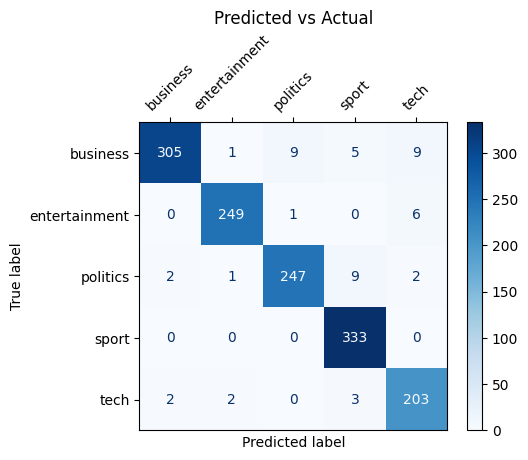

In [ ]:
# Test the model with train dataset
accuracy, labelorder, y_pred = nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, train_df, mapping_labels=mapping_labels)
print(f"Label order: {labelorder}, Accuracy on train dataset: {accuracy:.5f}")
plot_predicted_vs_actual(train_df['Category'].values, y_pred, display_labels=list(mapping_labels.keys()))

In [ ]:
# Test the model with test dataset.
_, _, y_pred = nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, test_df, mapping_labels=mapping_labels, labelorder=labelorder)
# Since we weren't given the labels for test dataset, we must submit the result to Kaggle in order to get the accuracy score.
filename = "submission-nmf-001.csv"
create_submission(filename, test_df['ArticleId'], y_pred)

In [49]:
# Display submission content
df = pd.read_csv(filename)
df

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


After submitted "submission-nmf-001.csv" file to Kaggle, we got the accuracy score: 0.97278

### Training NMF model with subset of train data

For the first try, We trained the model with both train and test data. We then tested the model with train dataset and test dataset separately. We got the accuracy score of 0.96256 on training set and 0.97278 (received from Kaggle) on test set. This time, we will train the model with a subset of train data only. We won't change any hyper-parameters yet. Let's see how it affects to the result. 

We'll split the train dataset into train and validation subsets. We'll train the model with train subsets and validate using validation subsets. We'll also submit the solutions to Kaggle to check the model's performance on test dataset.

In [ ]:
# Percentage of train subsets
train_sizes = [40, 50, 60, 70, 80, 90, 100]
for train_size in train_sizes:
    if train_size == 100:
        # Train and validation with full train dataset
        X_train = train_df
        X_val = train_df
    else:
        X_train, X_val = train_test_split(train_df, train_size=train_size/100, random_state=101, stratify=train_df['Label'])
    
    # Initialize TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.95, ngram_range=(1, 2), stop_words='english')
    tfidf_train = tfidf_vectorizer.fit_transform(X_train['LemmaText'])
    # Initialize NMF mdel
    nmf_model = NMF(n_components=5, random_state=0, init='nndsvda', solver='mu', beta_loss='kullback-leibler')
    nmf_model.fit(tfidf_train)
    # Test with train subset
    train_accuracy, labelorder, y_train_pred = nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, X_train, mapping_labels=mapping_labels)
    # Test with validation subset
    _, _, y_val_pred = nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, X_val, mapping_labels=mapping_labels, labelorder=labelorder)
    val_accuracy = accuracy_score(X_val['Category'].values, y_val_pred)
    print(f"Train size: {train_size}%, Validation size: {100-train_size}%, Train score: {train_accuracy:.5f}, Validation score: {val_accuracy:.5f}")
    # Test the model with test dataset and create submission.
    _, _, y_test_pred = nmf_fit_predict_accuracy(nmf_model, tfidf_vectorizer, test_df, mapping_labels=mapping_labels, labelorder=labelorder)
    filename = f"submission-nmf-train{train_size}-val{100-train_size}.csv"
    create_submission(filename, test_df['ArticleId'], y_test_pred)

Train size: 40%, Validation size: 60%, Train score: 0.94054, Validation score: 0.94964
Train size: 50%, Validation size: 50%, Train score: 0.94813, Validation score: 0.96115
Train size: 60%, Validation size: 40%, Train score: 0.95438, Validation score: 0.96403
Train size: 70%, Validation size: 30%, Train score: 0.95473, Validation score: 0.94724
Train size: 80%, Validation size: 20%, Train score: 0.94689, Validation score: 0.94245
Train size: 90%, Validation size: 10%, Train score: 0.94880, Validation score: 0.94964
Train size: 100%, Validation size: 0%, Train score: 0.95752, Validation score: 0.95752


After submitted to Kaggle, I got the corresponding results as followed:
| Train size | Validation size | Train score | Validation score | Test Score (Kaggle's) |
| :--------: | :-------------: | :---------: | :--------------: | :-------------------: |
| 40% | 60% | 0.94054 | 0.94964 | 0.94829 |
| 50% | 50% | 0.94813 | 0.96115 | 0.95510 |
| 60% | 40% | 0.95438 | 0.96403 | 0.96190 |
| 70% | 30% | 0.95473 | 0.94724 | 0.96190 |
| 80% | 20% | 0.94689 | 0.94245 | 0.96326 |
| 90% | 10% | 0.94880 | 0.94964 | 0.96326 |
| 100% | 100% | 0.95752 | 0.95752 | 0.96870|

**Observations:** The model's performance is higher when it's being trained with more data.

### Hyperparameter Tunning



So far we have tried with different subsets of training data. We found that the highest test score we achieved is 0.97278 with our first try, where we trained the model with both train and test data. Now we're going to test different hyper-parameters. In this experiment, we'll use sklearn's **Pipeline** and **GridSearchCV** to search for the best model based on the accuracy score.

In [66]:
from sklearn.pipeline import Pipeline
import time

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(random_state=0)),
])

param_grid = {
    #TfidfVectorizer parameters
    'tfidf__stop_words': ['english'],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [3, 4, 5],
    'tfidf__max_df': [0.5, 0.7, 0.9],
    #NMF parameters
    'nmf__n_components': [5],
    'nmf__init': ['nndsvda'],
    'nmf__solver': ['mu'],
    'nmf__alpha_W': [0.0, 0.5],
    'nmf__alpha_H': [0.0, 0.5],
    'nmf__max_iter': [300, 500],
    'nmf__beta_loss': ['kullback-leibler']
}

def custom_score(model, X, y):
    W = model.transform(X)
    #X_tfidf = model.named_steps['tfidf'].transform(X)
    #W = model.named_steps['nmf'].transform(X_tfidf)
    yp = np.argmax(W, axis=1)
    labelorder, acc = label_permute_compare(y,yp)
    #print(f'Label order: {labelorder},  Accuracy: {acc}')
    return acc
    

# Perform Grid Search
gridcv = GridSearchCV(pipeline, param_grid, cv=3, scoring=custom_score, n_jobs=-1)
time0 = time.time()
gridcv.fit(train_df['LemmaText'], train_df['Label'])
# Print best parameters and best score
print('Total execution time:', time.time() - time0)
print('Best Parameters:', gridcv.best_params_)
print('Best Validation Score:', gridcv.best_score_)

Total execution time: 69.9190788269043
Best Parameters: {'nmf__alpha_H': 0.5, 'nmf__alpha_W': 0.5, 'nmf__beta_loss': 'kullback-leibler', 'nmf__init': 'nndsvda', 'nmf__max_iter': 300, 'nmf__n_components': 5, 'nmf__solver': 'mu', 'tfidf__max_df': 0.5, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Best Validation Score: 0.964722822174226


Label order: (3, 2, 0, 1, 4), Accuracy: 0.97336
Confusion Matrix:
[[311   1   8   0   9]
 [  1 246   1   0   8]
 [  0   1 258   1   1]
 [  1   0   0 332   0]
 [  3   2   0   0 205]]


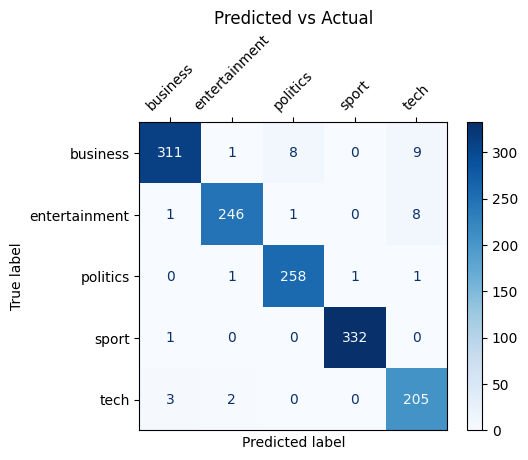

In [67]:
# Test best_estimator with the whole tran dataset
accuracy, labelorder, y_pred = nmf_fit_predict_accuracy(
    gridcv.best_estimator_.named_steps['nmf'], 
    gridcv.best_estimator_.named_steps['tfidf'], 
    train_df, 
    mapping_labels=mapping_labels
)
print(f"Label order: {labelorder}, Accuracy: {accuracy:.5f}")
plot_predicted_vs_actual(train_df['Category'].values, y_pred, display_labels=list(mapping_labels.keys()))

In [68]:
# Fit the model with test data and create the submission.
accuracy, labelorder, y_pred = nmf_fit_predict_accuracy(
    gridcv.best_estimator_.named_steps['nmf'], 
    gridcv.best_estimator_.named_steps['tfidf'], 
    test_df, 
    mapping_labels=mapping_labels, 
    labelorder=labelorder)
filename = "submission-nmf-002.csv"
create_submission(filename, test_df['ArticleId'], y_pred)
# Display submission content
df = pd.read_csv(filename)
df

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


After submitted the solution to Kaggle, I got the accuracy score of: 0.96734.

## Supervised Models

 Since the training data provided with labels (category), we can use supervised learning to solve the problem. In this section. We'll try 3 models: **SVC** (Support Vector Machine), **KNeighborsClassifier** (K-Nearest Neighbor) and **RandomForestClassifier**. We'll also use **TruncatedSVD** for dimensionality reduction.

### Support Vector Machine (SVC)

In [74]:
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

# Initialize TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.95, ngram_range=(1, 2), stop_words='english')
# Fit with both train and test data
merged_data = merged_data = pd.concat([train_df['LemmaText'], test_df['LemmaText']]).drop_duplicates()
tfidf_all = tfidf_vectorizer.fit_transform(merged_data)

svd = TruncatedSVD(n_components=2000).fit(tfidf_all)

X_train = train_df['LemmaText']
y_train = train_df['Category']
X_test = test_df["LemmaText"]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=101)

X_train_tfidf =  tfidf_vectorizer.transform(X_train)
X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf =  tfidf_vectorizer.transform(X_val)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

svc = SVC(kernel='rbf').fit(X_train_tfidf_svd, y_train)

print("SVC validation score: ", svc.score(X_val_tfidf_svd, y_val))

y_pred = svc.predict(X_test_tfidf_svd)

filename = "submission-svc.csv"
create_submission(filename, test_df['ArticleId'], y_pred)
# Display submission content
df = pd.read_csv(filename)
df

SVC validation score:  0.9820143884892086


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


**Observations:** SVC took 1m15s to complete. SVC validation score on 20% train dataset: 0.98201. SVC accuracy score on test dataset (recieved from Kaggle): 0.97959

## K-Nearest Neighbor Classifier

In [96]:
from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=100).fit(X_train_tfidf_svd, y_train)
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,100))
}

# Perform Grid Search
gridcv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
time0 = time.time()
gridcv.fit(X_train_tfidf_svd, y_train)

print("KNN validation score: ", gridcv.best_estimator_.score(X_val_tfidf_svd, y_val))

y_pred = gridcv.best_estimator_.predict(X_test_tfidf_svd)

filename = "submission-knn.csv"
create_submission(filename, test_df['ArticleId'], y_pred)
# Display submission content
df = pd.read_csv(filename)
df

KNN validation score:  0.9496402877697842


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,tech
733,206,business


After submitted to Kaggle, we got accuracy score: 0.95238

In [97]:
from sklearn.ensemble import RandomForestClassifier
import time

rf_model = RandomForestClassifier(max_features='sqrt', random_state=0)

param_grid = {
    #RandomForest
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 5, 10, 15, 20, 25, 30]
}

# Perform Grid Search with cross-validation
gridcv = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
time0 = time.time()
gridcv.fit(X_train_tfidf_svd, y_train)
print("RF validation score: ", gridcv.best_estimator_.score(X_val_tfidf_svd, y_val))
y_pred = gridcv.best_estimator_.predict(X_test_tfidf_svd)
filename = "submission-rf.csv"
create_submission(filename, test_df['ArticleId'], y_pred)
# Display submission content
df = pd.read_csv(filename)
df

RF validation score:  0.9640287769784173


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


After submitted to Kaggle, we got test score: 0.95510

## Summary

The following table summaries the results for all models we've tested so far in this project:

| Model | Train size | Validation size | Train score | Validation score | Kaggle's Test Score |
| :---: | :--------: | :-------------: | :---------: | :--------------: | :-------------------: |
| Unsupervised Learning | | | | | |
| NMF | 100% (train+test) | 100% (train) |  | 0.96256 | 0.97278 |
| NMF | 40% | 60% | 0.94054 | 0.94964 | 0.94829 |
| NMF | 50% | 50% | 0.94813 | 0.96115 | 0.95510 |
| NMF | 60% | 40% | 0.95438 | 0.96403 | 0.96190 |
| NMF | 70% | 30% | 0.95473 | 0.94724 | 0.96190 |
| NMF | 80% | 20% | 0.94689 | 0.94245 | 0.96326 |
| NMF | 90% | 10% | 0.94880 | 0.94964 | 0.96326 |
| NMF | 100% | 100% | 0.95752 | 0.95752 | 0.96870|
| NMF(hyper-prameter tunning) | 100% | 100% |  | 0.97336 | 0.96734|
| Supervised Learning | | | | | |
| SVC | 80% | 20% |  | 0.98201 | 0.97959 |
| KNN | 80% | 20% |  | 0.94964 | 0.95238 |
| RF | 80% | 20% |  | 0.96403 | 0.95510 |

- SVC is the winner of this test. It achieved the highest accuracy score (0.97959) on Kaggle's test set when traning on 80% training set.
- The best accuracy score on Kaggle’s test set with the NMF model is 0.97278 when trained on the entire training set plus test set.
- Comparing the supervised learning (SVC) and unsuppervised learning (NMF) model, SVC is outperformanced in this test. 

## References

1. [Step by Step Guide to Master NLP – Text Cleaning Techniques](https://www.analyticsvidhya.com/blog/2021/06/part-4-step-by-step-guide-to-master-natural-language-processing-in-python/)

2. [Lemmatization vs. Stemming: A Deep Dive into NLP's Text Normalization Techniques](https://www.geeksforgeeks.org/lemmatization-vs-stemming-a-deep-dive-into-nlps-text-normalization-techniques/)

3. [Stemming vs Lemmatization in NLP: Must-Know Differences](https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/)

4. [NLTK - Natural Language Toolkit](https://www.nltk.org)

5. [Top 14 Steps To Build A Complete NLTK Preprocessing Pipeline In Python](https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/)

6. [Understanding TF-IDF (Term Frequency-Inverse Document Frequency)](https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/)

7. [TF-IDF Made Simple & How To Get Started In Python Tutorial](https://spotintelligence.com/2022/11/28/tf-idf/)

8. [Non-Negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)

9. [Non-Negative Matrix Factorization Explained & Practical How To Guide In Python](https://spotintelligence.com/2023/09/08/non-negative-matrix-factorization/amp/)

10. [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)